# MIMIC-IV Exploratory Data Analysis

## Data Overview

We have 4 administrative/demographic tables from MIMIC-IV:

| Table | Granularity | Description |
|-------|-------------|-------------|
| **admissions** | Per hospital admission | Admit/discharge times, insurance, demographics |
| **patients** | Per patient | Gender, age, date of death |
| **diagnoses_icd** | Per diagnosis per admission | ICD codes assigned to each admission |
| **d_icd_diagnoses** | Per ICD code (lookup) | Human-readable diagnosis names |

**Note:** These tables do NOT contain ICU event-level data (labs, vitals, medications). Additional MIMIC tables would be needed for that analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

DATA_DIR = Path('data')

Matplotlib is building the font cache; this may take a moment.


## 1. Data Loading

The data is stored in RTF files with CSV content. We need to:
1. Strip the RTF header (first 9 lines)
2. Replace `\` line endings with actual newlines

In [2]:
def load_rtf_csv(filepath):
    """Load CSV data from an RTF file by stripping RTF formatting."""
    with open(filepath, 'r', encoding='utf-8', errors='replace') as f:
        content = f.read()
    
    # Find the start of CSV data (after RTF header)
    # The header line starts after the RTF preamble
    lines = content.split('\\\n')
    
    # First line contains RTF header + first CSV row
    # Find where the actual CSV header starts
    first_line = lines[0]
    # Look for common CSV headers
    for header in ['subject_id', 'icd_code']:
        if header in first_line:
            idx = first_line.find(header)
            lines[0] = first_line[idx:]
            break
    
    # Remove trailing RTF closing brace from last line
    lines[-1] = lines[-1].rstrip('}').strip()
    
    # Join and create DataFrame
    csv_content = '\n'.join(lines)
    from io import StringIO
    return pd.read_csv(StringIO(csv_content))

In [3]:
# Load all tables
print("Loading admissions...")
admissions = load_rtf_csv(DATA_DIR / 'mimic_admissions.rtf')

print("Loading patients...")
patients = load_rtf_csv(DATA_DIR / 'Mimic_Patients_file.rtf')

print("Loading diagnoses_icd...")
diagnoses_icd = load_rtf_csv(DATA_DIR / 'Mimic_diagnosis_icd.rtf')

print("Loading d_icd_diagnoses...")
d_icd_diagnoses = load_rtf_csv(DATA_DIR / 'Mimic_d_icd_diagnoses.rtf')

print("\nAll tables loaded successfully!")

Loading admissions...
Loading patients...
Loading diagnoses_icd...
Loading d_icd_diagnoses...

All tables loaded successfully!


## 2. Basic EDA - Shape, Types, Missing Values

In [4]:
def summarize_table(df, name):
    """Print summary statistics for a DataFrame."""
    print(f"\n{'='*60}")
    print(f"TABLE: {name}")
    print(f"{'='*60}")
    print(f"\nShape: {df.shape[0]:,} rows x {df.shape[1]} columns")
    print(f"\nColumns and Types:")
    print(df.dtypes.to_string())
    print(f"\nMissing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
    print(missing_df[missing_df['Missing'] > 0].to_string() if missing.sum() > 0 else "No missing values")
    print(f"\nFirst 3 rows:")
    display(df.head(3))

In [5]:
summarize_table(admissions, 'ADMISSIONS')


TABLE: ADMISSIONS

Shape: 431,088 rows x 15 columns

Columns and Types:
subject_id               int64
hadm_id                  int64
admittime               object
dischtime               object
deathtime               object
admission_type          object
admission_location      object
discharge_location      object
insurance               object
language                object
marital_status          object
race                    object
edregtime               object
edouttime               object
hospital_expire_flag     int64

Missing Values:
                    Missing  Percent
deathtime            422463    98.00
discharge_location   119314    27.68
marital_status         9220     2.14
edregtime            131828    30.58
edouttime            131828    30.58

First 3 rows:


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0


In [6]:
summarize_table(patients, 'PATIENTS')


TABLE: PATIENTS

Shape: 299,777 rows x 6 columns

Columns and Types:
subject_id            int64
gender               object
anchor_age            int64
anchor_year           int64
anchor_year_group    object
dod                  object

Missing Values:
     Missing  Percent
dod   270689     90.3

First 3 rows:


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN


In [7]:
summarize_table(diagnoses_icd, 'DIAGNOSES_ICD')


TABLE: DIAGNOSES_ICD

Shape: 4,752,265 rows x 5 columns

Columns and Types:
subject_id      int64
hadm_id         int64
seq_num         int64
icd_code       object
icd_version     int64

Missing Values:
No missing values

First 3 rows:


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9


In [8]:
summarize_table(d_icd_diagnoses, 'D_ICD_DIAGNOSES')


TABLE: D_ICD_DIAGNOSES

Shape: 109,775 rows x 3 columns

Columns and Types:
icd_code       object
icd_version     int64
long_title     object

Missing Values:
No missing values

First 3 rows:


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"


## 3. Granularity Verification

In [9]:
print("GRANULARITY CHECK")
print("="*50)

# Patients: should be 1 row per subject_id
print(f"\nPatients:")
print(f"  Total rows: {len(patients):,}")
print(f"  Unique subject_ids: {patients['subject_id'].nunique():,}")
print(f"  -> Granularity: {'Patient-level ✓' if len(patients) == patients['subject_id'].nunique() else 'NOT patient-level'}")

# Admissions: should be 1 row per hadm_id
print(f"\nAdmissions:")
print(f"  Total rows: {len(admissions):,}")
print(f"  Unique hadm_ids: {admissions['hadm_id'].nunique():,}")
print(f"  Unique subject_ids: {admissions['subject_id'].nunique():,}")
print(f"  -> Granularity: {'Admission-level ✓' if len(admissions) == admissions['hadm_id'].nunique() else 'NOT admission-level'}")
print(f"  -> Avg admissions per patient: {len(admissions) / admissions['subject_id'].nunique():.2f}")

# Diagnoses: multiple per admission
print(f"\nDiagnoses ICD:")
print(f"  Total rows: {len(diagnoses_icd):,}")
print(f"  Unique hadm_ids: {diagnoses_icd['hadm_id'].nunique():,}")
print(f"  -> Granularity: Diagnosis-level (multiple per admission)")
print(f"  -> Avg diagnoses per admission: {len(diagnoses_icd) / diagnoses_icd['hadm_id'].nunique():.2f}")

# ICD lookup
print(f"\nD_ICD_Diagnoses (lookup table):")
print(f"  Total rows: {len(d_icd_diagnoses):,}")
print(f"  Unique ICD codes: {d_icd_diagnoses['icd_code'].nunique():,}")
print(f"  ICD versions present: {d_icd_diagnoses['icd_version'].unique().tolist()}")

GRANULARITY CHECK

Patients:
  Total rows: 299,777
  Unique subject_ids: 299,777
  -> Granularity: Patient-level ✓

Admissions:
  Total rows: 431,088
  Unique hadm_ids: 431,088
  Unique subject_ids: 180,747
  -> Granularity: Admission-level ✓
  -> Avg admissions per patient: 2.39

Diagnoses ICD:
  Total rows: 4,752,265
  Unique hadm_ids: 430,708
  -> Granularity: Diagnosis-level (multiple per admission)
  -> Avg diagnoses per admission: 11.03

D_ICD_Diagnoses (lookup table):
  Total rows: 109,775
  Unique ICD codes: 109,282
  ICD versions present: [9, 10]


## 4. Categorical Variable Analysis

In [10]:
# Admissions categorical columns
print("ADMISSIONS - Categorical Value Counts")
print("="*50)

cat_cols = ['admission_type', 'admission_location', 'discharge_location', 
            'insurance', 'language', 'marital_status', 'race']

for col in cat_cols:
    print(f"\n{col.upper()}:")
    print(admissions[col].value_counts().head(10).to_string())

ADMISSIONS - Categorical Value Counts

ADMISSION_TYPE:
admission_type
EW EMER.                       149491
EU OBSERVATION                  94857
OBSERVATION ADMIT               52389
URGENT                          44731
SURGICAL SAME DAY ADMISSION     34140
DIRECT EMER.                    19518
DIRECT OBSERVATION              18768
ELECTIVE                        10555
AMBULATORY OBSERVATION           6639

ADMISSION_LOCATION:
admission_location
EMERGENCY ROOM                            232683
PHYSICIAN REFERRAL                        114734
TRANSFER FROM HOSPITAL                     36030
WALK-IN/SELF REFERRAL                      15743
CLINIC REFERRAL                            10018
PROCEDURE SITE                              7822
PACU                                        5495
INTERNAL TRANSFER TO OR FROM PSYCH          4173
TRANSFER FROM SKILLED NURSING FACILITY      3852
INFORMATION NOT AVAILABLE                    356

DISCHARGE_LOCATION:
discharge_location
HOME              

In [11]:
# Patients categorical columns
print("PATIENTS - Categorical Value Counts")
print("="*50)

print(f"\nGENDER:")
print(patients['gender'].value_counts().to_string())

print(f"\nANCHOR_YEAR_GROUP:")
print(patients['anchor_year_group'].value_counts().to_string())

PATIENTS - Categorical Value Counts

GENDER:
gender
F    158550
M    141227

ANCHOR_YEAR_GROUP:
anchor_year_group
2008 - 2010    96798
2011 - 2013    72486
2014 - 2016    68139
2017 - 2019    62352
2020 - 2022        2


In [12]:
# Hospital mortality
print("HOSPITAL MORTALITY (hospital_expire_flag)")
print("="*50)
print(admissions['hospital_expire_flag'].value_counts())
mortality_rate = admissions['hospital_expire_flag'].mean() * 100
print(f"\nIn-hospital mortality rate: {mortality_rate:.2f}%")

HOSPITAL MORTALITY (hospital_expire_flag)
hospital_expire_flag
0    422450
1      8638
Name: count, dtype: int64

In-hospital mortality rate: 2.00%


## 5. Date Range Analysis

In [13]:
# Convert date columns
date_cols = ['admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime']
for col in date_cols:
    admissions[col] = pd.to_datetime(admissions[col], errors='coerce')

patients['dod'] = pd.to_datetime(patients['dod'], errors='coerce')

print("DATE RANGES")
print("="*50)
print(f"\nAdmissions:")
print(f"  Earliest admission: {admissions['admittime'].min()}")
print(f"  Latest admission: {admissions['admittime'].max()}")
print(f"  Date range: {(admissions['admittime'].max() - admissions['admittime'].min()).days / 365:.1f} years")

DATE RANGES

Admissions:
  Earliest admission: 2105-10-04 17:26:00
  Latest admission: 2212-04-06 12:13:00
  Date range: 106.6 years


In [14]:
# Length of stay
admissions['los_days'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / 86400

print("LENGTH OF STAY (days)")
print("="*50)
print(admissions['los_days'].describe())

LENGTH OF STAY (days)
count    431088.000000
mean          4.479912
std           6.607742
min          -0.945139
25%           1.069444
50%           2.734722
75%           5.236111
max         295.988194
Name: los_days, dtype: float64


## 6. Numeric Distributions

In [15]:
print("AGE DISTRIBUTION (anchor_age)")
print("="*50)
print(patients['anchor_age'].describe())

AGE DISTRIBUTION (anchor_age)
count    299777.000000
mean         48.530037
std          20.884980
min          18.000000
25%          29.000000
50%          48.000000
75%          65.000000
max          91.000000
Name: anchor_age, dtype: float64


## 7. Visualizations

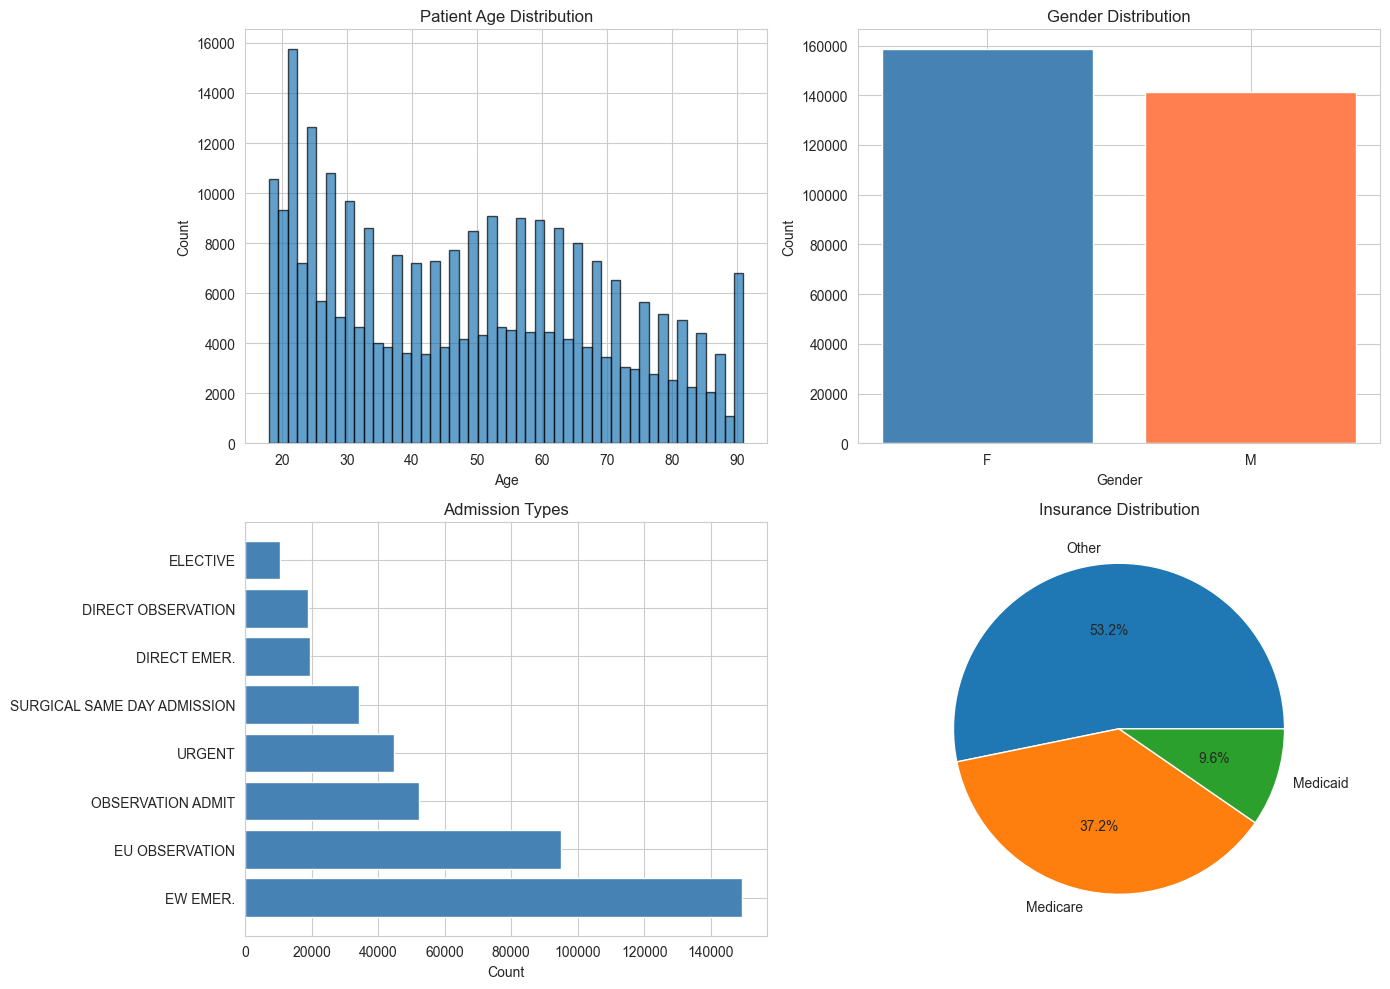

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(patients['anchor_age'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Patient Age Distribution')

# Gender distribution
gender_counts = patients['gender'].value_counts()
axes[0, 1].bar(gender_counts.index, gender_counts.values, color=['steelblue', 'coral'])
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Gender Distribution')

# Admission type
adm_type = admissions['admission_type'].value_counts().head(8)
axes[1, 0].barh(adm_type.index, adm_type.values, color='steelblue')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_title('Admission Types')

# Insurance
ins_counts = admissions['insurance'].value_counts()
axes[1, 1].pie(ins_counts.values, labels=ins_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('Insurance Distribution')

plt.tight_layout()
plt.show()

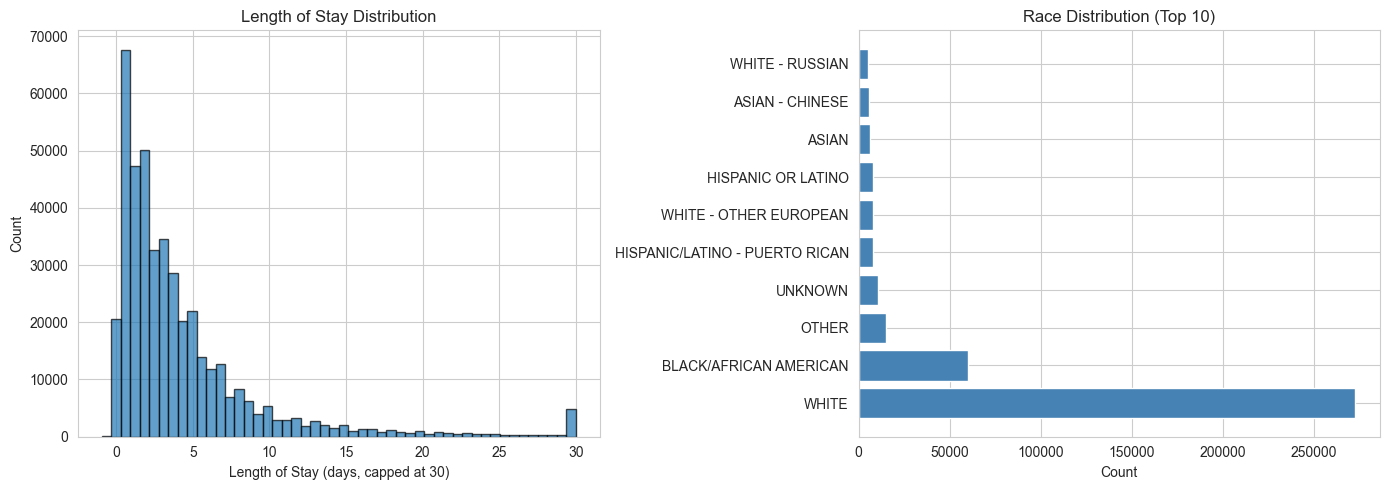

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Length of stay distribution (capped for visualization)
los_capped = admissions['los_days'].clip(upper=30)
axes[0].hist(los_capped, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Length of Stay (days, capped at 30)')
axes[0].set_ylabel('Count')
axes[0].set_title('Length of Stay Distribution')

# Race distribution
race_counts = admissions['race'].value_counts().head(10)
axes[1].barh(race_counts.index, race_counts.values, color='steelblue')
axes[1].set_xlabel('Count')
axes[1].set_title('Race Distribution (Top 10)')

plt.tight_layout()
plt.show()

## 8. Cross-Table Analysis: Top Diagnoses

In [18]:
# Join diagnoses with lookup table to get readable names
diagnoses_with_names = diagnoses_icd.merge(
    d_icd_diagnoses[['icd_code', 'icd_version', 'long_title']], 
    on=['icd_code', 'icd_version'], 
    how='left'
)

print(f"Diagnoses with names: {len(diagnoses_with_names):,} rows")
print(f"Missing titles: {diagnoses_with_names['long_title'].isna().sum():,}")
diagnoses_with_names.head()

Diagnoses with names: 4,752,265 rows
Missing titles: 0


,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
0,10000032,22595853,1,5723,9,Portal hypertension
1,10000032,22595853,2,78959,9,Other ascites
2,10000032,22595853,3,5715,9,Cirrhosis of liver without mention of alcohol
3,10000032,22595853,4,07070,9,Unspecified viral hepatitis C without hepatic ...
4,10000032,22595853,5,496,9,"Chronic airway obstruction, not elsewhere clas..."


In [19]:
# Top 20 diagnoses
top_diagnoses = diagnoses_with_names['long_title'].value_counts().head(20)

print("TOP 20 DIAGNOSES")
print("="*50)
for i, (diag, count) in enumerate(top_diagnoses.items(), 1):
    print(f"{i:2}. {diag[:60]:<60} {count:>8,}")

TOP 20 DIAGNOSES
 1. Unspecified essential hypertension                             97,474
 2. Other and unspecified hyperlipidemia                           64,019
 3. Essential (primary) hypertension                               51,621
 4. Hyperlipidemia, unspecified                                    48,463
 5. Acute kidney failure, unspecified                              47,898
 6. Esophageal reflux                                              46,279
 7. Diabetes mellitus without mention of complication, type II o   40,970
 8. Personal history of nicotine dependence                        38,765
 9. Anemia, unspecified                                            36,590
10. Atrial fibrillation                                            35,331
11. Congestive heart failure, unspecified                          34,912
12. Depressive disorder, not elsewhere classified                  34,493
13. Coronary atherosclerosis of native coronary artery             34,317
14. Gastro-esophageal

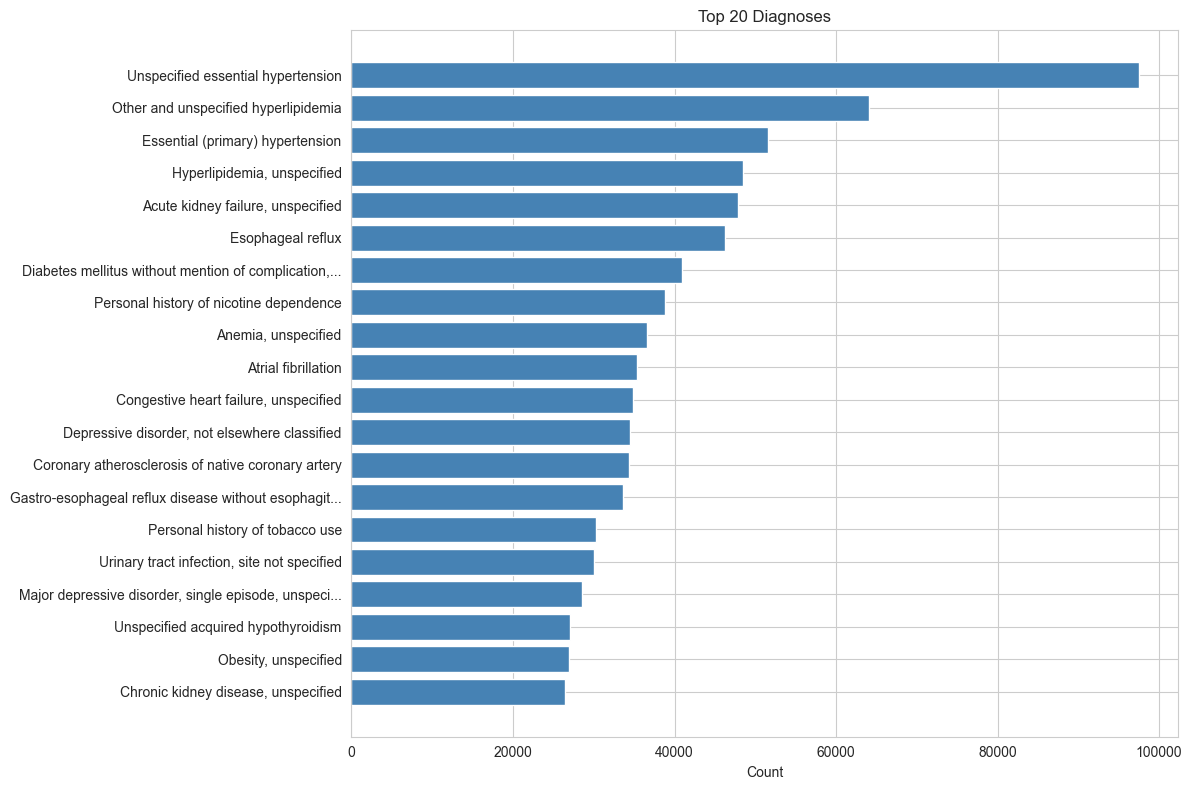

In [20]:
# Visualize top diagnoses
plt.figure(figsize=(12, 8))
top_20 = diagnoses_with_names['long_title'].value_counts().head(20)
plt.barh(range(len(top_20)), top_20.values, color='steelblue')
plt.yticks(range(len(top_20)), [t[:50] + '...' if len(t) > 50 else t for t in top_20.index])
plt.xlabel('Count')
plt.title('Top 20 Diagnoses')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Mortality Analysis

In [21]:
# Merge patients with admissions
patient_admissions = admissions.merge(patients, on='subject_id', how='left')
print(f"Combined patient-admissions: {len(patient_admissions):,} rows")

# Mortality by age group
patient_admissions['age_group'] = pd.cut(
    patient_admissions['anchor_age'], 
    bins=[0, 30, 50, 65, 80, 100],
    labels=['18-30', '31-50', '51-65', '66-80', '81+']
)

mortality_by_age = patient_admissions.groupby('age_group')['hospital_expire_flag'].agg(['mean', 'count'])
mortality_by_age['mean'] = (mortality_by_age['mean'] * 100).round(2)
mortality_by_age.columns = ['Mortality Rate (%)', 'N Admissions']
print("\nMortality by Age Group:")
print(mortality_by_age)

Combined patient-admissions: 431,088 rows

Mortality by Age Group:
           Mortality Rate (%)  N Admissions
age_group                                  
18-30                    0.28         51267
31-50                    0.80        102684
51-65                    1.72        123613
66-80                    2.97        101694
81+                      4.87         51830


/var/folders/8j/vmh4lq_x6r77_84w1j1sbv1m0000gn/T/ipykernel_19440/528130393.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_by_age = patient_admissions.groupby('age_group')['hospital_expire_flag'].agg(['mean', 'count'])


In [22]:
# Mortality by admission type
mortality_by_type = admissions.groupby('admission_type')['hospital_expire_flag'].agg(['mean', 'count'])
mortality_by_type['mean'] = (mortality_by_type['mean'] * 100).round(2)
mortality_by_type.columns = ['Mortality Rate (%)', 'N Admissions']
mortality_by_type = mortality_by_type.sort_values('Mortality Rate (%)', ascending=False)
print("\nMortality by Admission Type:")
print(mortality_by_type)


Mortality by Admission Type:
                             Mortality Rate (%)  N Admissions
admission_type                                               
URGENT                                     3.68         44731
EW EMER.                                   3.50        149491
DIRECT EMER.                               2.09         19518
OBSERVATION ADMIT                          2.02         52389
ELECTIVE                                   0.74         10555
SURGICAL SAME DAY ADMISSION                0.36         34140
DIRECT OBSERVATION                         0.12         18768
EU OBSERVATION                             0.08         94857
AMBULATORY OBSERVATION                     0.02          6639


/var/folders/8j/vmh4lq_x6r77_84w1j1sbv1m0000gn/T/ipykernel_19440/702570397.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_by_age_plot = patient_admissions.groupby('age_group')['hospital_expire_flag'].mean() * 100


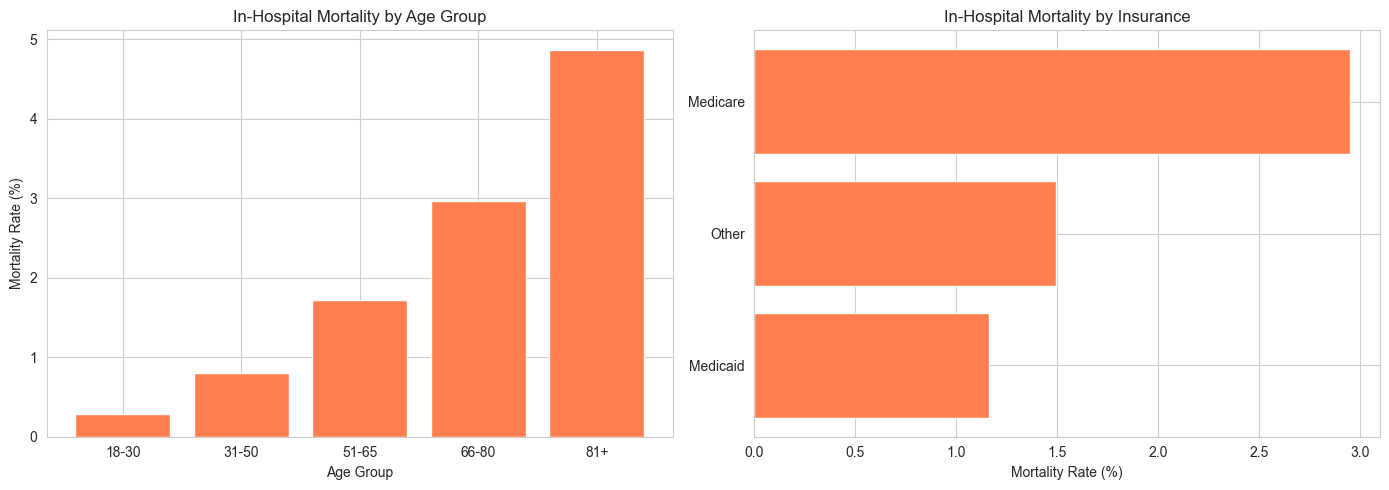

In [23]:
# Visualize mortality
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By age group
mortality_by_age_plot = patient_admissions.groupby('age_group')['hospital_expire_flag'].mean() * 100
axes[0].bar(mortality_by_age_plot.index.astype(str), mortality_by_age_plot.values, color='coral')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Mortality Rate (%)')
axes[0].set_title('In-Hospital Mortality by Age Group')

# By insurance
mortality_by_ins = admissions.groupby('insurance')['hospital_expire_flag'].mean() * 100
mortality_by_ins = mortality_by_ins.sort_values(ascending=True)
axes[1].barh(mortality_by_ins.index, mortality_by_ins.values, color='coral')
axes[1].set_xlabel('Mortality Rate (%)')
axes[1].set_title('In-Hospital Mortality by Insurance')

plt.tight_layout()
plt.show()

## 10. Summary Statistics

In [24]:
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"\nTotal unique patients: {patients['subject_id'].nunique():,}")
print(f"Total hospital admissions: {len(admissions):,}")
print(f"Total diagnoses recorded: {len(diagnoses_icd):,}")
print(f"Unique ICD codes used: {diagnoses_icd['icd_code'].nunique():,}")
print(f"\nOverall in-hospital mortality rate: {admissions['hospital_expire_flag'].mean()*100:.2f}%")
print(f"Median length of stay: {admissions['los_days'].median():.1f} days")
print(f"Mean age at anchor: {patients['anchor_age'].mean():.1f} years")
print(f"\nPatients with recorded death (dod): {patients['dod'].notna().sum():,} ({patients['dod'].notna().mean()*100:.1f}%)")


SUMMARY

Total unique patients: 299,777
Total hospital admissions: 431,088
Total diagnoses recorded: 4,752,265
Unique ICD codes used: 25,843

Overall in-hospital mortality rate: 2.00%
Median length of stay: 2.7 days
Mean age at anchor: 48.5 years

Patients with recorded death (dod): 29,088 (9.7%)
